# Ensemble model

In [1]:
import os

import numpy as np
import pandas as pd

os.environ["KERAS_BACKEND"] = "jax"
import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from utilsforecast.data import generate_series

print("----- versions -----")
print(f"keras\t {keras.__version__:>11}")
print(f"pandas\t {pd.__version__:>11}")
print(f"numpy\t {np.__version__:>11}")

----- versions -----
keras	       3.9.2
pandas	       2.2.3
numpy	       2.1.3


## Generate synthetic data and perform train test split

<Axes: >

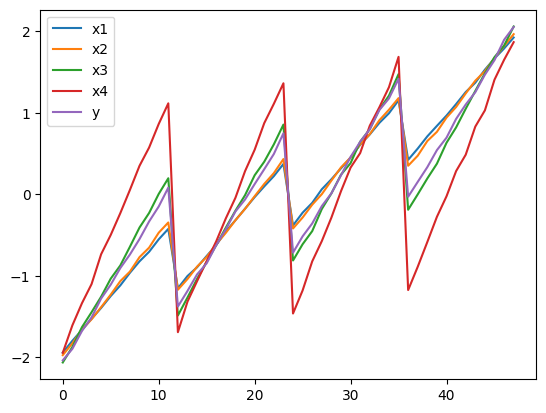

In [3]:
series = generate_series(
    n_series=5,
    freq="MS",
    min_length=60,
    max_length=60,
    with_trend=True,
    equal_ends=True,
)

df = pd.DataFrame()
df.index = series[series["unique_id"] == 0]["ds"].values
df.index = df.index.to_period("M")

df["x1"] = series[series["unique_id"] == 0]["y"].values
df["x2"] = series[series["unique_id"] == 1]["y"].values
df["x3"] = series[series["unique_id"] == 2]["y"].values
df["x4"] = series[series["unique_id"] == 3]["y"].values
df["y"] = series[series["unique_id"] == 4]["y"].values

df_train = df[df.index < "2004"].copy()
df_test = df[df.index >= "2004"].copy()

std = StandardScaler()
df_train = std.fit_transform(df_train)
df_test = std.transform(df_test)

pd.DataFrame(df_train, columns=std.feature_names_in_).plot()

## Model 1: VAR

In [4]:
model = VAR(df_train)
model_fit_var = model.fit(maxlags=12)
model_fit_var.summary()

/home/sk/Projects/TimeSeriesAnalysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/vector_ar/var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Apr, 2025
Time:                     03:30:51
---------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    -317.566
Nobs:                     36.0000    HQIC:                   -326.300
Log likelihood:           6007.27    FPE:               -6.94354e-149
AIC:                     -330.982    Det(Omega_mle):    -4.88916e-151
---------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.326521         0.000000     30107713.029           0.000
L1.y1          0.178427         0.000000     29117183.022           0.000
L1.y2         -0.114821              NAN              NAN             NAN
L1.y3      

In [5]:
result_var = model_fit_var.forecast(df_train[-12:], steps=12)

## Model 2: MLP

In [7]:
LAG = 12
df_train_mlp = np.array(
    [df_train[i - LAG - 1 : i] for i in range(LAG + 1, len(df_train))]
)
df_mlp_x = df_train_mlp[:, :LAG, :]
df_mlp_y = df_train_mlp[:, LAG, :]

df_mlp_x.shape, df_mlp_y.shape

((35, 12, 5), (35, 5))

In [8]:
from keras.layers import Dense, Flatten, Input

mlp_forecaster = keras.Sequential(
    layers=[
        Input(shape=(LAG, 5)),
        Flatten(),
        Dense(
            256,
            activation=keras.activations.relu,
            # kernel_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
            # bias_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
        ),
        Dense(
            128,
            activation=keras.activations.relu,
            # kernel_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
            # bias_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
        ),
        Dense(
            5,
            activation=keras.activations.linear,
            # kernel_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
            # bias_regularizer=keras.regularizers.L1L2(l1=0.1, l2=0.1),
        ),
    ],
    trainable=True,
    name="mpl_forecaster",
)

mlp_forecaster.summary()

mlp_forecaster.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=3e-3),
    loss=keras.losses.mean_squared_error,
    # metrics=keras.metrics.mean_abs,
)
mlp_train_hist = mlp_forecaster.fit(
    df_mlp_x, df_mlp_y, epochs=100, validation_split=0.2
)

Model: "mpl_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,157 (192.02 KB)

 Trainable params: 49,157 (192.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.7403 - val_loss: 0.8825
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3251 - val_loss: 0.2324
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2002 - val_loss: 0.0585
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1111 - val_loss: 0.1386
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0905 - val_loss: 0.2662
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0988 - val_loss: 0.2905
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0755 - val_loss: 0.2246
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0391 - val_loss: 0.1403
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0822
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0240 - val_loss: 0.0554
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - val_loss: 0.0480
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - val_loss: 0.046

In [9]:
def regressive_predict(model, train_df, num_steps, lag):
    result = []
    train_df_new = train_df.copy()
    for _ in range(num_steps):
        pred = model.predict(train_df_new[-LAG:].reshape(1, LAG, 5))
        train_df_new = np.vstack([train_df_new, pred])
        result.append(pred)
    return np.array(result).reshape(num_steps, 5)

In [10]:
result_mlp = regressive_predict(mlp_forecaster, df_train, 12, 12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


# Model 3: LSTM

In [11]:
from keras.layers import LSTM, Dense, Flatten, Input

lstm_forecaster = keras.Sequential(
    layers=[
        Input(shape=(LAG, 5)),
        LSTM(128),
        Dense(64, activation=keras.activations.relu),
        Dense(5, activation=keras.activations.linear),
    ],
    trainable=True,
    name="lstm_forecaster",
)

lstm_forecaster.summary()

lstm_forecaster.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-2),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.RootMeanSquaredError],
)
lstm_forecaster_hist = lstm_forecaster.fit(
    df_mlp_x, df_mlp_y, epochs=100, validation_split=0.2
)

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,189 (301.52 KB)

 Trainable params: 77,189 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.5463 - root_mean_squared_error: 0.7391 - val_loss: 0.8757 - val_root_mean_squared_error: 0.9358
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.3884 - root_mean_squared_error: 0.6232 - val_loss: 0.5975 - val_root_mean_squared_error: 0.7730
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3709 - root_mean_squared_error: 0.6090 - val_loss: 0.3316 - val_root_mean_squared_error: 0.5758
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3042 - root_mean_squared_error: 0.5515 - val_loss: 0.2852 - val_root_mean_squared_error: 0.5341
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3039 - root_mean_squared_error: 0.5513 - val_loss: 0.4342 - val_root_mean_squared_error: 0.6590
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2566 - root_mean_squared_error: 0.5065 - val_loss: 0.3645 - val_root_mean_squared_error: 0.6037
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.24

In [14]:
result_lstm = regressive_predict(lstm_forecaster, df_train, 12, 12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


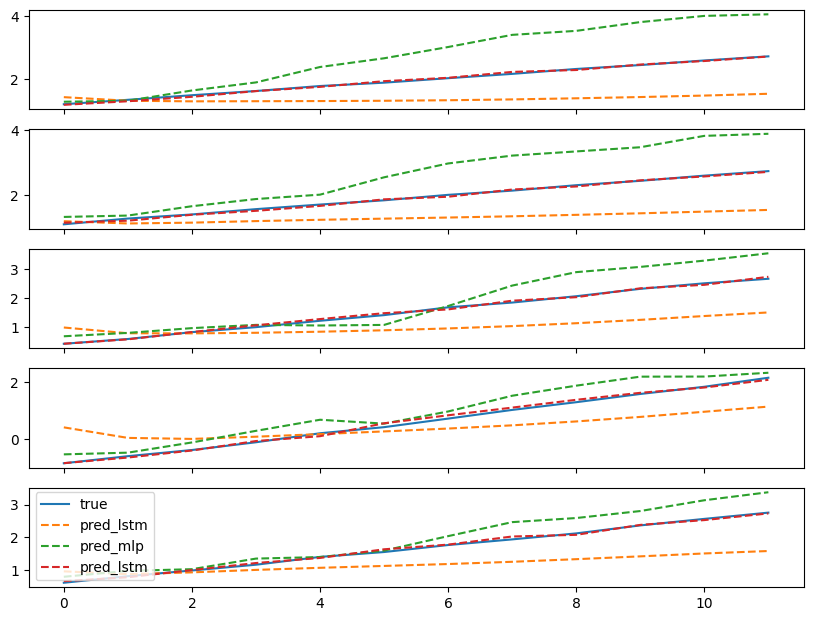

In [23]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(7.5)
for idx, axis in enumerate(ax):
    axis.plot(df_test[:, idx], label="true")
    axis.plot(result_lstm[:, idx], "--", label="pred_lstm")
    axis.plot(result_mlp[:, idx], "--", label="pred_mlp")
    axis.plot(result_var[:, idx], "--", label="pred_lstm")
axis.legend()

## ENSEMBLE

In [21]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

mase = MeanAbsoluteScaledError(sp=12)
mase_var = mase(df_test, result_var, y_train=df_train)
mase_mlp = mase(df_test, result_mlp, y_train=df_train)
mase_lstm = mase(df_test, result_lstm, y_train=df_train)

mase_var, mase_mlp, mase_lstm

(np.float64(0.06855386650074027),
 np.float64(0.8203452265540787),
 np.float64(0.9773870287458704))

In [22]:
losses = np.array([mase_var, mase_mlp, mase_lstm])
loss_inv = 1 / losses
weight = loss_inv / sum(loss_inv)
weight

array([0.86677117, 0.07243355, 0.06079528])